###Setup Notebook
Import all required libaries and access google drive contents

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils import data
from torch.utils.data.sampler import SubsetRandomSampler

import torchvision
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt

from PIL import Image
import cv2

In [2]:
!nvidia-smi

Wed Dec  2 16:47:17 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.38       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    25W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [4]:
models_filepath = '/content/gdrive/My Drive/ECE496 Capstone/Models/'
streets_dataset_filepath = '/content/gdrive/My Drive/ECE496 Capstone/Datasets/STREETS'

###Load Data
Load images and mask from STREETS dataset

In [5]:
import os
import glob
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import random
import torchvision.transforms.functional as TF
from sklearn.utils import shuffle

"""
convert mask to binary mask using threshold
"""
def apply_binary_image_thresholding(mask, threshold=0.5, cuda_allow=False):
    if mask.is_cuda:
        ones_array = torch.ones(mask.shape, device=torch.device('cuda:0'))
        zeros_array = torch.zeros(mask.shape, device=torch.device('cuda:0'))
        threshold_array = ones_array * threshold
    else:
        ones_array = torch.ones(mask.shape)
        zeros_array = torch.zeros(mask.shape)
        threshold_array = ones_array * threshold

    cond = torch.greater(mask, threshold_array)
    mask = torch.where(cond, ones_array, zeros_array)
    torch.cuda.empty_cache() # Clean up gpu cache
    return mask

class StreetsDataset(Dataset):
    def __init__(self, image_paths, target_paths, bin_threshold=0.5):
        self.image_paths = image_paths
        self.target_paths = target_paths
        self.bin_threshold = bin_threshold
        
        self.transforms = transforms.Compose([transforms.Resize((128, 256)), transforms.ToTensor()])

    def __getitem__(self, index):
        image = Image.open(self.image_paths[index])
        mask = Image.open(self.target_paths[index])
        t_image = self.transforms(image)
        t_mask = self.transforms(mask)
        t_mask = apply_binary_image_thresholding(t_mask, threshold=self.bin_threshold)

        return t_image, t_mask

    def __len__(self):
        return len(self.image_paths)

def get_data_loaders_and_dataset(data_paths, target_paths, batch_size=16, train_split=70, val_split=15):
    data_paths = sorted(data_paths)
    target_paths = sorted(target_paths)

    num_data = len(data_paths)

    train_idx = int(num_data * train_split/100.)
    val_idx = train_idx + int(num_data * val_split/100.)

    data_paths, target_paths = shuffle(data_paths, target_paths)

    train_ds = StreetsDataset(data_paths[:train_idx], target_paths[:train_idx])
    val_ds = StreetsDataset(data_paths[train_idx:val_idx], target_paths[train_idx:val_idx])
    test_ds = StreetsDataset(data_paths[val_idx:], target_paths[val_idx:])

    print('{} train, {} validation, {} testing samples'.format(len(train_ds), len(val_ds), len(test_ds)))

    num_workers = 1
    train_loader = torch.utils.data.DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    val_loader = torch.utils.data.DataLoader(val_ds, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    test_loader = torch.utils.data.DataLoader(test_ds, batch_size=batch_size, shuffle=True, num_workers=num_workers)

    return train_ds, val_ds, test_ds, train_loader, val_loader, test_loader

In [6]:
streets_ds_images_filepath = streets_dataset_filepath + '/images/*'
streets_ds_target_filepath = streets_dataset_filepath + '/mask/*'


streets_data_paths = glob.glob(streets_ds_images_filepath)
streets_target_paths = glob.glob(streets_ds_target_filepath)

num_streets_data = len(streets_data_paths)
num_streets_target = len(streets_target_paths)

print('Found {} data / {} targets in {}'.format(num_streets_data, num_streets_target, streets_dataset_filepath))
assert num_streets_data == num_streets_target, 'Unequal number of images and masks for STREETS dataset'

# split data into train/validation/test 70-15-15
train_ds, val_ds, test_ds, train_loader, val_loader, test_loader = get_data_loaders_and_dataset(\
                data_paths=streets_data_paths, target_paths=streets_target_paths, \
                batch_size=16, train_split=70, val_split=15)

Found 2949 data / 2949 targets in /content/gdrive/My Drive/ECE496 Capstone/Datasets/STREETS
2064 train, 442 validation, 443 testing samples


###View target masks on image
Do a sanity check on data by checking first image and mask target 

In [7]:
def display_masked_image(img, mask, display=True):
    res = img
    res[0] = img[0] + mask[0] * 0.6   # make mask items red
    res[res > 1] = 1

    if res.shape[0] == 1:
        res = np.squeeze(res, axis=0)
    else:
        res = np.moveaxis(res, 0, -1)

    if display:
        plt.imshow(res)
        plt.show()
    return res

In [8]:
def display_one_image_from_loader(loader):        
    dataiter_train = iter(loader)
    images, targets = dataiter_train.next()

    images = images.numpy()[0]
    masks = targets.numpy()[0]
    display_masked_image(images, masks)

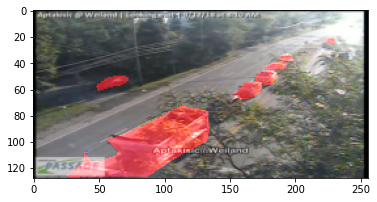

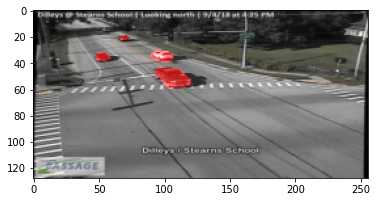

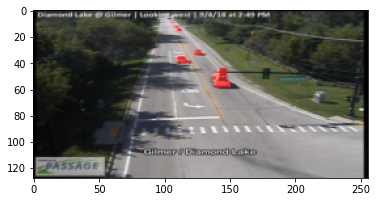

In [9]:
display_one_image_from_loader(train_loader)
display_one_image_from_loader(val_loader)
display_one_image_from_loader(test_loader)

###Define Models

###### very simple convolutional autoencoder - tried and works (very bad)

In [10]:
class Simple_Autoencoder(nn.Module):
    def __init__(self):
        super(Simple_Autoencoder, self).__init__()
        self.encoder = nn.Sequential( 
            nn.Conv2d(3, 16, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 64, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, 7)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 7),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 16, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1),
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

###### vgg16 pretrained - tried and works

In [11]:
encode_out = []
def hook(module, input, output):
	encode_out.append(output)

class TrafficCamera_Vgg(nn.Module):
  def __init__(self):
    super(TrafficCamera_Vgg, self).__init__()

    vgg = torchvision.models.vgg.vgg16(pretrained=True)

    # Maxpool output layers
    # NEED TO ADJUST ENCODING OUTPUT LAYERS
    # vgg19 = [4,9,18,27,36]
    # vgg16 = [4,9,16,23,30]
    # vgg11 = [2,5,10,15,20]
    self.encoder_out_layers = [4,9,16,23,30]

    self.vgg = vgg

    # Freeze weights
    for param in self.vgg.features.parameters():
      param.requires_grad = False

    # Save intermediate output values
    for i in self.encoder_out_layers:
      self.vgg.features[i].register_forward_hook(hook)

    self.deconv1 = nn.ConvTranspose2d(512, 512, 3, stride=2, padding=1, output_padding=1)
    self.deconv_bn_layer1 = nn.BatchNorm2d(512)
    self.deconv_dropout1 = nn.Dropout(p=0.5)

    self.deconv2 = nn.ConvTranspose2d(512+512, 256, 3, stride=2, padding=1, output_padding=1)
    self.deconv_bn_layer2 = nn.BatchNorm2d(256)
    self.deconv_dropout2 = nn.Dropout(p=0.5)

    self.deconv3 = nn.ConvTranspose2d(256+256, 128, 3, stride=2, padding=1, output_padding=1)
    self.deconv_bn_layer3 = nn.BatchNorm2d(128)
    self.deconv_dropout3 = nn.Dropout(p=0.5)

    self.deconv4 = nn.ConvTranspose2d(128+128, 64, 3, stride=2, padding=1, output_padding=1)
    self.deconv_bn_layer4 = nn.BatchNorm2d(64)
    self.deconv_dropout4 = nn.Dropout(p=0.5)

    self.deconv5 = nn.ConvTranspose2d(64+64, 3, 3, stride=2, padding=1, output_padding=1)
    self.deconv_bn_layer5 = nn.BatchNorm2d(3)
    self.deconv_dropout5 = nn.Dropout(p=0.5)

    self.deconv6 = nn.ConvTranspose2d(3+3, 1, 3, stride=1, padding=1)
    self.deconv_bn_layer6 = nn.BatchNorm2d(1)
    self.deconv_dropout6 = nn.Dropout(p=0.5)

  def forward(self, img):
    encode_out.clear()
    out = self.vgg.features(img)

    out = F.relu(self.deconv_bn_layer1(self.deconv1(encode_out[-1])))
    out = self.deconv_dropout1(out)

    out = torch.cat((out, encode_out[-2]), 1)
    out = F.relu(self.deconv_bn_layer2(self.deconv2(out)))
    out = self.deconv_dropout1(out)


    out = torch.cat((out, encode_out[-3]),1)
    out = F.relu(self.deconv_bn_layer3(self.deconv3(out)))
    out = self.deconv_dropout1(out)

    out = torch.cat((out, encode_out[-4]),1)
    out = F.relu(self.deconv_bn_layer4(self.deconv4(out)))
    out = self.deconv_dropout1(out)

    out = torch.cat((out, encode_out[-5]),1)
    out = F.relu(self.deconv_bn_layer5(self.deconv5(out)))
    out = self.deconv_dropout1(out)

    out = torch.cat((out, img),1)
    out = self.deconv_bn_layer6(self.deconv6(out))
    out = self.deconv_dropout1(out)

    return out

###### resnet pretrained - untested

In [12]:
encode_out_r = []
def hook_r(module, input, output):
    encode_out_r.append(output)

class deconvBlock(nn.Module):
    def __init__(self, in_channels, out_channels,
                 kernel_size=3, stride=2,
                 padding=1, output_padding=0, with_bn = False,
                 with_activation=True, act_type='R'):
        super().__init__()

        self.deconv_layer = nn.ConvTranspose2d(in_channels,
                                               out_channels,
                                               kernel_size=kernel_size,
                                               stride=stride,
                                               padding=padding,
                                               output_padding=output_padding)
        self.deconv_bn_layer = nn.BatchNorm2d(out_channels)
        self.deconv_dropout = nn.Dropout(p=0.5)
        if (act_type == 'R'):
            self.deconv_activation = nn.ReLU()
        else:
            self.deconv_activation = nn.PReLU()

        self.bn_flag = with_bn
        self.act_flag = with_activation

    def forward(self, input):
        out = self.deconv_layer(input)

        #if self.bn_flag:
        out = self.deconv_bn_layer(out)

        if self.act_flag:
            out = self.deconv_activation(out)
        
        out = self.deconv_dropout(out)
        return out

class TrafficCamera_Res(nn.Module):
    def __init__(self, act_type="R", r_size = 50):
        super(TrafficCamera_Res, self).__init__()

        if r_size == 152:
            resnet = torchvision.models.resnet152(pretrained=True)
        elif r_size == 101:
            resnet = torchvision.models.resnet101(pretrained=True)
        else:
            resnet = torchvision.models.resnet50(pretrained=True)

        # Maxpool output layers
        self.encoder_out_layers = [resnet.conv1,
                                   resnet.maxpool,
                                   resnet.layer1[0].downsample[-1],
                                   resnet.layer2[0].downsample[-1],
                                   resnet.layer3[0].downsample[-1],
                                   resnet.layer4[-1].relu]

        self.res = nn.Sequential(*list(resnet.children())[:-2])

        # Freeze weights
        for param in self.res.parameters():
            param.requires_grad = False

        # Save intermediate output values
        for layer in self.encoder_out_layers:
            layer.register_forward_hook(hook_r)

        self.deconv1 = deconvBlock(2048, 1024, 3, stride=2, padding=1, output_padding=1, act_type = act_type)
        self.deconv2 = deconvBlock(1024 + 1024, 512, 3, stride=2, padding=1, output_padding=1, act_type = act_type)
        self.deconv3 = deconvBlock(512 + 512, 256, 3, stride=2, padding=1, output_padding=1, act_type = act_type)
        self.deconv4 = deconvBlock(256 + 256, 64, 3, stride=1, padding=1, act_type = act_type)
        self.deconv5 = deconvBlock(64 + 64, 64, 3, stride=2, padding=1, output_padding=1, act_type = act_type)
        self.deconv6 = deconvBlock(64 + 64, 3, 3, stride=2, padding=1, output_padding=1, act_type = act_type)
        self.deconv7 = deconvBlock(3, 1, 3, stride=1, padding=1, with_activation=False, act_type = act_type)


    def forward(self, img):
        global encode_out_r
        encode_out_r = []

        out_res = self.res(img)
        out = self.deconv1(encode_out_r[-1])
        # print(out.shape)

        out = torch.cat((out, encode_out_r[-4]), 1)
        out = self.deconv2(out)
        # print(out.shape)

        out = torch.cat((out, encode_out_r[-5]), 1)
        out = self.deconv3(out)
        # print(out.shape)

        out = torch.cat((out, encode_out_r[-6]), 1)
        out = self.deconv4(out)
        # print(out.shape)

        out = torch.cat((out, encode_out_r[-7]), 1)
        out = self.deconv5(out)
        # print(out.shape)

        out = torch.cat((out, encode_out_r[-8]), 1)
        out = self.deconv6(out)
        # print(out.shape)

        #out = torch.cat((out, img), 1)
        out = self.deconv7(out)

        return out

###Define Loss Function

###### Using BCE and Dice Coefficient as loss function
Loss function from: https://becominghuman.ai/image-masking-challenge-a-kaggle-competition-5a66f30aa335
Sample code taken from: https://www.kaggle.com/kmader/vgg16-u-net-on-carvana
Dice coefficient vs Jaccard Index - https://stats.stackexchange.com/questions/238684/what-are-the-difference-between-dice-jaccard-and-overlap-coefficients

In [13]:
def get_dice_coeff(mask_true, mask_pred, epsilon=1e-10):
    intersection = torch.sum(mask_true * mask_pred, axis=(1,2,3))
    union = torch.sum(mask_true, axis=(1,2,3)) + torch.sum(mask_pred, axis=(1,2,3))
    return torch.mean(2. * intersection / (union + epsilon), axis=0)

class LossBCEDice:
    """
    Loss defined as BCE + (1 - Dice_Coeff)
    """
    def __init__(self, bce_weight=1):
        self.bce_loss = nn.BCEWithLogitsLoss()
        self.bce_weight = bce_weight

    def __call__(self, outputs, targets):
        binary_outputs = apply_binary_image_thresholding(outputs, cuda_allow=True)
        dice_coeff = get_dice_coeff(targets, binary_outputs)
        loss = self.bce_weight * self.bce_loss(outputs, targets) + (1 - dice_coeff)
        return loss

def get_accuracy_and_loss(dataset, criterion, model, batch_size=32, num_workers=4):
    losses, accuracy = [], []
    sigmoid = nn.Sigmoid()

    for imgs, labels in iter(torch.utils.data.DataLoader(dataset, batch_size=batch_size, num_workers=num_workers)):
        if torch.cuda.is_available():
            imgs = imgs.cuda()
            labels = labels.cuda()
        out = model(imgs)
        loss_batch = criterion(out, labels)
        losses.append(loss_batch.detach().item())

        out = sigmoid(out)
        out = apply_binary_image_thresholding(out, cuda_allow=True)
        acc_batch = get_dice_coeff(labels, out, epsilon=1e-10)
        # acc_batch = torch.sum(out == labels, dtype=torch.float) / torch.numel(out)
        accuracy.append(acc_batch)

    acc = torch.mean(torch.tensor(accuracy))
    loss = torch.mean(torch.tensor(losses))

    torch.cuda.empty_cache() # Clean up gpu cache

    return acc, loss

In [14]:
# ones_table = np.zeros((1, 1, 10, 10))
# ones_table[0, 0, 0, :] = 1
# zeros_table = np.ones((1, 1, 10, 10))
# print(zeros_table.shape, ones_table.shape)
# print(type(zeros_table), type(ones_table))
# print(ones_table)
# print(zeros_table)
# print(get_dice_coeff(ones_table, zeros_table))

### Training Function

In [15]:
#Garbage Collection
import gc

def train(model, train_dataset, val_dataset, learning_rate, batch_size, num_epochs, model_name=""):
    if torch.cuda.is_available():
      model.cuda()

    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = LossBCEDice()

    iters, train_loss, val_loss, train_acc, val_acc = [], [], [], [],[]
    for epoch in range(num_epochs):
        
        model.train()
        gc.collect() # Garbage Collection
        
        # if cuda is still running out of memory try adjusting the dataloader
        for imgs, labels in iter(torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=8)):
            imgs = imgs.cuda()      
            labels = labels.cuda()
            out = model(imgs)             # forward pass
            loss = criterion(out, labels) # compute the total loss
            loss.backward()               # backward pass (compute parameter updates)
            optimizer.step()              # make the updates for each parameter
            optimizer.zero_grad()         # a clean up step for PyTorch

        model.eval()
        torch.cuda.empty_cache() # Clean up gpu cache
        
        # save the current training information          
        #torch.save(model.state_dict(), model_name+str(n))
        iters.append(epoch)

        # Validation Loss and Accuracy
        jaccard = []
        losses = []

        val_acc_epoch, val_loss_epoch = get_accuracy_and_loss(val_dataset, criterion, model, batch_size=batch_size, num_workers=4)
        val_acc.append(val_acc_epoch)
        val_loss.append(val_loss_epoch)

        train_acc_epoch, train_loss_epoch = get_accuracy_and_loss(train_dataset, criterion, model, batch_size=batch_size, num_workers=4)
        train_acc.append(train_acc_epoch)
        train_loss.append(train_loss_epoch)

        print('Epoch {}, Train Acc: {:.4f} Loss: {:.4f} Valid Acc: {:.4f} Loss: {:.4f}'.format(epoch, train_acc_epoch, train_loss_epoch, val_acc_epoch, val_loss_epoch))
        
    # plotting
    plt.title("Training Accuracy")
    plt.plot(iters, train_acc, label="Train")
    plt.plot(iters, val_acc, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()

    plt.title("Training Loss")
    plt.plot(iters, train_loss, label="Train")
    plt.plot(iters, val_loss, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

    np.savetxt("{}_train_loss.csv".format(model_name), train_loss)
    np.savetxt("{}_train_acc.csv".format(model_name), train_acc)
    np.savetxt("{}_val_loss.csv".format(model_name), val_loss)
    np.savetxt("{}_val_acc.csv".format(model_name), val_acc)

    torch.save(model.state_dict(), models_filepath + model_name + ".pt")
    print("Final Training Accuracy: {}".format(train_acc[-1]))
    print("Final Validation Accuracy: {}".format(val_acc[-1]))

### Training Model
uncomment the line below the dotted line to actually train

In [16]:
batch_size = 16
num_epochs = 30
learning_rate = 0.001

debug_data_paths = streets_data_paths[:500]
debug_target_paths = streets_target_paths[:500]

# split data into train/validation/test 70-15-15
train_ds, val_ds, test_ds, train_loader, val_loader, test_loader = get_data_loaders_and_dataset(\
                data_paths=streets_data_paths, target_paths=streets_target_paths, \
                batch_size=batch_size, train_split=70, val_split=15)

model = TrafficCamera_Vgg()
model_name = 'vgg'
#------------------------------------ uncomment to train ------------------------------------------------------------------------
# train(model, train_ds, val_ds, learning_rate=learning_rate, batch_size=batch_size, num_epochs=num_epochs, model_name=model_name)

2064 train, 442 validation, 443 testing samples


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


###Testing Model
Find accuracy of test set and look at some examples

In [17]:
# Load saved model
model = TrafficCamera_Vgg()
model_name = 'vgg'

model.load_state_dict(torch.load(models_filepath + model_name + ".pt"))
model.eval()

if torch.cuda.is_available():
    model.cuda()

In [18]:
test_acc, test_loss = get_accuracy_and_loss(test_ds, LossBCEDice(), model, batch_size=16, num_workers=4)
print('Testing Accuracy {:.4f} | Testing Loss {:.4f} using model "{}"'.format(test_acc, test_loss, model_name))

Testing Accuracy 0.8176 | Testing Loss 0.3625 using model "vgg"


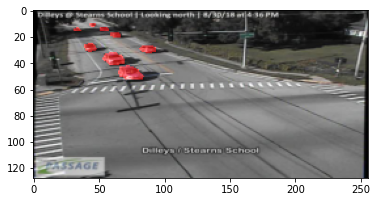

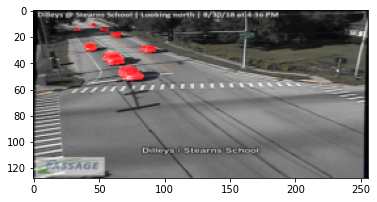

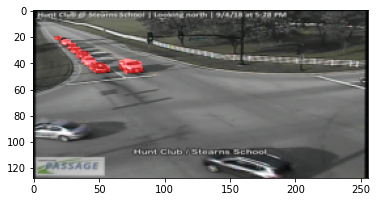

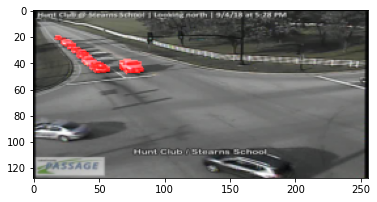

In [19]:
def display_one_model_mask(loader):
    sigmoid = nn.Sigmoid()

    dataiter_train = iter(loader)
    images, targets = dataiter_train.next()

    if next(model.parameters()).is_cuda:
        images_model = images.cuda()
    out = model(images_model)
    out = sigmoid(out)
    out = apply_binary_image_thresholding(out)

    image = images.numpy()[0]
    targets = targets.numpy()[0]
    mask = out.cpu().detach().numpy()[0]

    display_masked_image(image, targets)
    display_masked_image(image, mask)

display_one_model_mask(val_loader)
display_one_model_mask(test_loader)

###Creating bounding boxes around masked regions

<Figure size 1728x720 with 0 Axes>

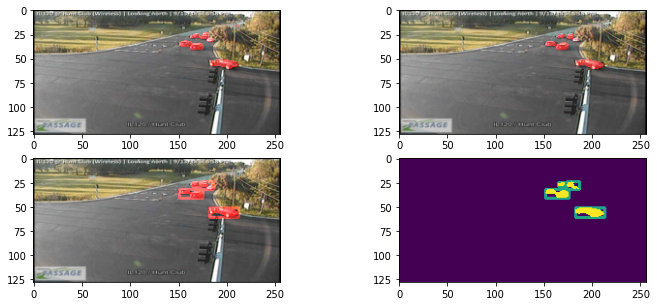

In [20]:
def find_bounding_boxes(mask, only_bounding_boxes=False):
    mask_orig = mask.copy()
    zeros_array = np.zeros(mask.shape)
    # display_masked_image(mask, zeros_array)

    mask = np.squeeze(mask)
    zeros_array = np.zeros(mask.shape)

    mask = np.uint8(mask * 255)
    contours = cv2.findContours(mask, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    if only_bounding_boxes:
       mask = zeros_array.copy()
    idx = 0 
    for cnt in contours[0]:
        idx += 1
        x,y,w,h = cv2.boundingRect(cnt)
        mask = cv2.rectangle(mask,(x,y),(x+w,y+h),(1),2)

    mask = np.expand_dims(mask, axis=0)
    # display_masked_image(mask_orig, mask, display=False)
    return mask

def display_one_model_mask_with_boxes(loader):
    sigmoid = nn.Sigmoid()

    dataiter_train = iter(loader)
    images, targets = dataiter_train.next()

    if next(model.parameters()).is_cuda:
        images_model = images.cuda()
    out = model(images_model)
    out = sigmoid(out)
    out = apply_binary_image_thresholding(out)

    image = images.numpy()[0]
    targets = targets.numpy()[0]
    mask = out.cpu().detach().numpy()[0]
    bound_boxes = find_bounding_boxes(mask.copy())

    truth_plt = display_masked_image(image.copy(), targets.copy(), display=False)
    masked_plt = display_masked_image(image.copy(), mask.copy(), display=False)
    bounding_plt = display_masked_image(image.copy(), bound_boxes.copy(), display=False)
    bounding_masks_plt = display_masked_image(mask.copy(), bound_boxes.copy(), display=False)

    plt.figure(figsize=(24,10))
    f, axarr = plt.subplots(2,2, figsize=(12,5))
    axarr[0, 0].imshow(truth_plt)
    axarr[0, 1].imshow(masked_plt)
    axarr[1, 0].imshow(bounding_plt)
    axarr[1, 1].imshow(bounding_masks_plt)

display_one_model_mask_with_boxes(test_loader)

###Code to draw bounding boxes over image - interim demo **function**

(128, 256, 3)


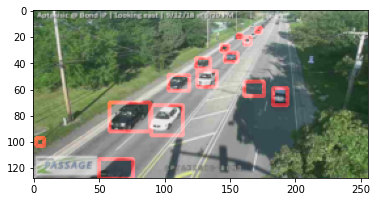

In [51]:
def draw_bounding_boxes_on_image(image):
    sigmoid = nn.Sigmoid()
    image_model = torch.unsqueeze(image, axis=0)

    if next(model.parameters()).is_cuda:
        image_model = image_model.cuda()
    out = model(image_model)
    out = sigmoid(out)
    out = apply_binary_image_thresholding(out)

    image = image.numpy()
    mask = out.cpu().detach().numpy()
    bound_boxes = find_bounding_boxes(mask.copy(), only_bounding_boxes=True)
    return display_masked_image(image.copy(), bound_boxes.copy(), display=False)

# example usage
image = Image.open(streets_dataset_filepath + '/images/Aptakisic at Bond IP East-3.jpg')
image_transforms = transforms.Compose([transforms.Resize((128, 256)), transforms.ToTensor()])
t_image = image_transforms(image)
masked_image = draw_bounding_boxes_on_image(t_image)  # this function takes in 1 image and returns the same image with the bounding boxes
plt.imshow(masked_image)
plt.show()

### Tracking and ID'ing Bounding Boxes

# Code For Loading Video From YouTube


In [22]:
!pip install pytube

from pytube import YouTube, Stream

     |████████████████████████████████| 40kB 3.7MB/s 


In [23]:
"""
Retrieves video from youtube in smallest mp4 format available and saves it to videos folder in working directory
"""
def get_video_youtube(url):

    current_path = os.getcwd()

    """
    ensures video folder exists in project root directory
    """
    if not path.isdir(current_path + r"/videos"):
        os.mkdir(current_path + r"/videos")

    save_path = current_path + r"/videos"

    """
    Gets youtube object, identifies the smallest stream and downloads it
    """
    youtube_object = YouTube(url)
    video_path = youtube_object.streams.filter(progressive=True, file_extension='mp4').get_lowest_resolution().download(save_path)

    return video_path

# Code For Segmenting Video to Images

In [24]:
from cv2 import VideoCapture, imwrite, resize, CAP_PROP_FRAME_COUNT, CAP_PROP_FRAME_HEIGHT, CAP_PROP_FRAME_WIDTH, CAP_PROP_FPS, VideoWriter, VideoWriter_fourcc, imread
import os
from os import path
import time
from google.colab.patches import cv2_imshow

In [25]:
"""
Checks that the path goes to a file
"""
def check_file_path(video_path):
    if video_path == None:
        print("No video file provided")
        return False    

    if not path.exists(video_path):
        print("Invalid Path")
        return False

    if not path.isfile(video_path):
        print("Input must be file")
        return False

    return True

"""
Get and reutrns the details for the video pointed to by the file path
"""
def video_details(video_path):
    check_file_path(video_path)

    video = VideoCapture(video_path)

    if not video.isOpened():
        print("Unable to open file. Please ensure input video is either .AVI or .MKV")
        return False

    total_video_frames = video.get(CAP_PROP_FRAME_COUNT)
    frame_height = video.get(CAP_PROP_FRAME_HEIGHT)
    frame_width = video.get(CAP_PROP_FRAME_WIDTH)
    video_fps = video.get(CAP_PROP_FPS)
    video_length = total_video_frames / video_fps
    print(total_video_frames)
    print(frame_height)
    print(frame_width)
    print(video_fps)  
    print(video_length)

    video.release()

    return total_video_frames, video_fps, frame_height, frame_width, video_length

"""
Extracts frames from the video at a selected frame rate
"""
def image_extraction(video_path = None, image_per_second = 10, target_height = 128, target_width = 256):
    """
    Checks validity of provided video file path
    """
    if(check_file_path(video_path) == False):
        return False

    total_video_frames, video_fps, _, _, _ = video_details(video_path)

    """
    loads video
    """
    video = VideoCapture(video_path)

    if not video.isOpened():
        print("Unable to open file. Please ensure input video is either .AVI or .MKV")
        return False

    _, video_name = os.path.split(video_path)

    video_name = video_name.split(".")

    """
    gets working directory
    """
    current_path = os.getcwd()

    """
    ensures image folder exists in project root directory
    """
    if not path.isdir(current_path + r"/images"):
        os.mkdir(current_path + r"/images")

    image_path = current_path + r"/images/" + video_name[0]

    if not path.isdir(image_path):
        os.mkdir(image_path)    

    print(image_path)


    begin = time.time()

    """
    iterates through loaded video and extracts frames
    at intervals dictated by save_interal 
    """
    frame_count = 0
    scale = (target_width, target_height)
    save_interval = int(video_fps / image_per_second)
    while(frame_count < total_video_frames):
        
        valid, image = video.read()

        if not valid:
            print("END")
            break

        if(valid and frame_count % save_interval == 0):
            image = resize(image, scale)
            image_name = image_path + "/" + video_name[0] + "_frame_{:08d}.jpg".format(frame_count)
            imwrite(image_name, image)

        frame_count += 1

    end = time.time()

    total_time = end - begin

    video.release()

    print(total_time)
    return image_path

# Code For Generating Video From Images

In [26]:
def make_video(image_path, size, fps):

    current_path = os.getcwd()

    images = []
    names = []

    for image in os.listdir(image_path):
        names.append(image)
        img = imread(os.path.join(image_path, image))
        images.append(img)

    out = [x for _, x in sorted(zip(names,images))]

    if not path.isdir(current_path + r"/generatedvideos"):
        os.mkdir(current_path + r"/generatedvideos")

    name = image_path.split("/")
    print(name[len(name)-1])

    video_path = current_path + r"/generatedvideos/" + name[len(name)-1] + r".avi"

    codex = VideoWriter_fourcc(*'MP4V')
    writer = VideoWriter(video_path, codex, fps, (size[1],size[0]))

    for image in out:
        # cv2_imshow(image)
        writer.write(image)
    writer.release()

In [87]:
def run_model_on_url(url):

    size = (128,256)
    fps = 10

    video_path = get_video_youtube(url)
    image_path = image_extraction(video_path, fps, size[0], size[1])

    current_path = os.getcwd()

    if not path.isdir(current_path + r"/processed_images"):
        os.mkdir(current_path + r"/processed_images")

    video_name = image_path.split("/")

    processed_path = current_path + r"/processed_images/" + video_name[-1]

    if not path.isdir(processed_path):
        os.mkdir(processed_path)

    image_transforms = transforms.Compose([transforms.Resize((128, 256)), transforms.ToTensor()])
    for image in os.listdir(image_path):
        # print(image_path + image)
        img = Image.open(image_path + "/" + image)
        
        t_image = image_transforms(img)
        # img = np.transpose(img, (2, 0, 1))
        # tensor_img = torch.from_numpy(img)
        # tensor_img = tensor_img.float()
        img_out = draw_bounding_boxes_on_image(t_image)
        # img_out = np.transpose(img_out, (2, 0, 1))
        # plt.imshow(img_out)
        # plt.show()
        img_out = cv2.cvtColor(img_out*255,cv2.COLOR_RGB2BGR)
        out_path = processed_path + "/Processed_" + image
        imwrite(out_path, img_out)

    make_video(processed_path, size, fps)

In [88]:
run_model_on_url("https://www.youtube.com/watch?v=MNn9qKG2UFI&ab_channel=KarolMajek")

9184.0
360.0
640.0
30.0
306.1333333333333
/content/images/4K Road traffic video for object detection and tracking - free download now!
11.806091070175171
4K Road traffic video for object detection and tracking - free download now!
